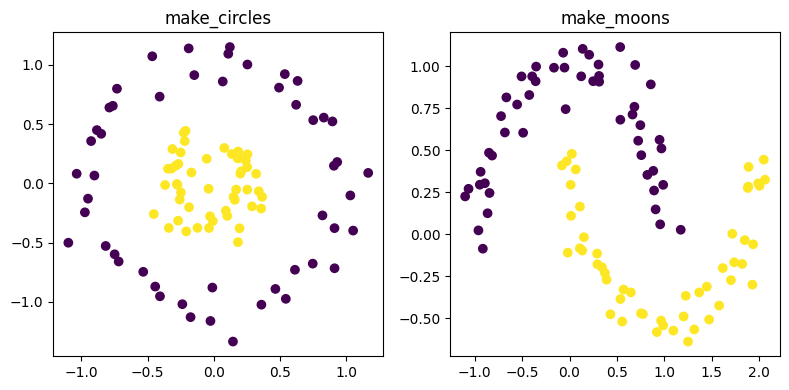

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

X, Y = make_circles(noise=0.1, factor=0.3, random_state=0)
ax1.scatter(X[:, 0], X[:, 1], c=Y)
ax1.set_title("make_circles")

X, Y = make_moons(noise=0.1, random_state=0)
ax2.scatter(X[:, 0], X[:, 1], c=Y)
ax2.set_title("make_moons")

plt.tight_layout()
plt.show()

In [2]:
import micrograd

In [20]:
X, Y = make_circles(noise=0.1, random_state=0)
X = X.tolist()
Y = Y.tolist()
len(X), len(Y)

(100, 100)

In [56]:
YY = [1 if y == 1 else - 1 for y in Y]

In [49]:
model = micrograd.MLP(2, [2, 3, 1])

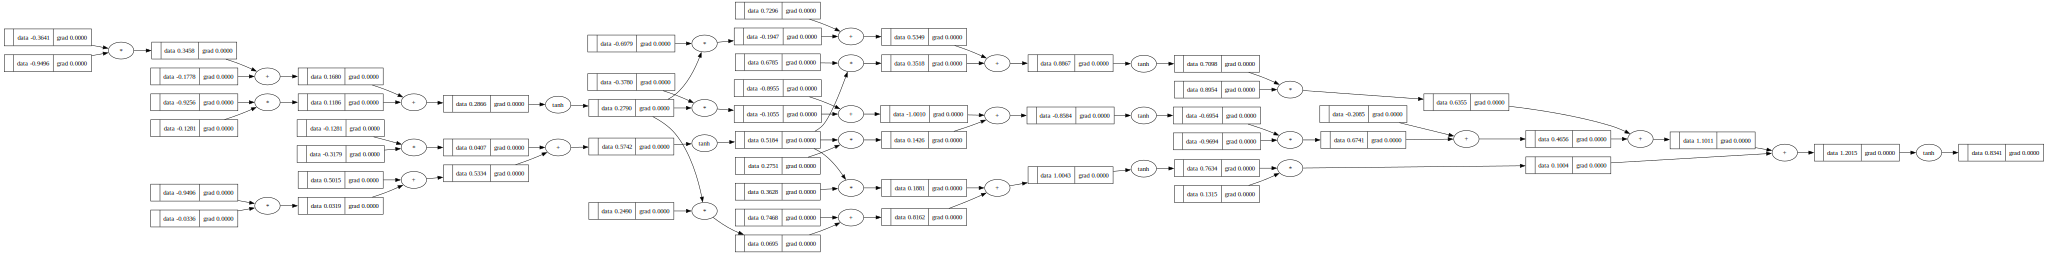

In [22]:
micrograd.draw_dot(model(X[0]))

In [68]:
model = micrograd.MLP(2, [2, 40, 40, 1])

for e in range(20):
    pred = [model(x) for x in X]
    loss = [(ypred - y)**2 for y, ypred in zip (YY, pred)]

    

    MSE = 0
    for l in loss:
        l.backward()
        MSE += l.data
    MSE /= len(loss)

    for p in model.parameters():
        p.data -= 0.005 * p.grad

    print('epoch: {}, loss: {}'.format(e, MSE))


epoch: 0, loss: 1.9498538651820092
epoch: 1, loss: 1.3500325226417034
epoch: 2, loss: 1.9999999767900556
epoch: 3, loss: 1.9999999999999898
epoch: 4, loss: 2.0
epoch: 5, loss: 2.0
epoch: 6, loss: 2.0
epoch: 7, loss: 2.0
epoch: 8, loss: 2.0
epoch: 9, loss: 2.0
epoch: 10, loss: 2.0
epoch: 11, loss: 2.0
epoch: 12, loss: 2.0
epoch: 13, loss: 2.0
epoch: 14, loss: 2.0
epoch: 15, loss: 2.0
epoch: 16, loss: 2.0
epoch: 17, loss: 2.0
epoch: 18, loss: 2.0
epoch: 19, loss: 2.0


0.2472354634441962


In [70]:
# Value class starter code, with many functions taken out

import math

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"


  def __truediv__(self, other): # self / other
    return self * (other ** -1)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
      
  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __sub__(self, other): # self - other
    return self + (-other)

  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), '*')

      def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
      out._backward = _backward

      return out
      
  
  def exp(self):
      out = Value(math.exp(self.data), (self,), 'exp')

      def _backward():
          self.grad += out.data * out.grad
      out._backward = _backward
      return out

 
  def log(self):
    # Forward pass
    import math  # or from math import log at the top, then just call log(...)
    out = Value(math.log(self.data), (self,), 'log')
    
    def _backward():
        # derivative of log(x) wrt x is 1/x
        self.grad += (1.0 / self.data) * out.grad
    
    out._backward = _backward
    return out 

    
  def __neg__(self):
    out = Value(-self.data, (self,), 'neg')

    def _backward():
        self.grad += -out.grad  # derivative of -x is -1
    out._backward = _backward
    return out  


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def sigmoid(self):
    x = self.data
    s = 1 / (1 + math.exp(-x))
    out = Value(s, (self, ), 'sigmoid')
    
    def _backward():
      self.grad += s * (1 - s) * out.grad

    out._backward = _backward
    return out
       
  def backward(self): # exactly as in video  
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


import random

class Neuron:
  
  def __init__(self, nin, activation='tanh'):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
    self.activation = activation
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    if self.activation == 'tanh':
        out = act.tanh()
    elif self.activation == 'sigmoid':
        out = act.sigmoid()
    else:
      raise NotImplementedError
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    activation = 'tanh' if nout > 1 else 'sigmo
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

